Este proyecto consiste en predecir la rentabilidad de los articulos del menu de un Retaurante. Este dataset fue extraido de Kaggle. La variable objetivo de este proyecto es la rentabilidad (Profitability)

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [31]:
df = pd.read_csv('/Users/mariosanchez/Desktop/Proyectos Machine Learning/Proyecto Restaurant_Menu/restaurant_menu_optimization_data.csv')

## Análisis exploratorio

In [32]:
df.head(3)

,RestaurantID,MenuCategory,MenuItem,Ingredients,Price,Profitability
0,R003,Beverages,Soda,['confidential'],2.55,Low
1,R001,Appetizers,Spinach Artichoke Dip,"['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']",11.12,Medium
2,R003,Desserts,New York Cheesecake,"['Chocolate', 'Butter', 'Sugar', 'Eggs']",18.66,High


In [33]:
df.shape

(1000, 6)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RestaurantID   1000 non-null   object 
 1   MenuCategory   1000 non-null   object 
 2   MenuItem       1000 non-null   object 
 3   Ingredients    1000 non-null   object 
 4   Price          1000 non-null   float64
 5   Profitability  1000 non-null   object 
dtypes: float64(1), object(5)
memory usage: 47.0+ KB


In [35]:
df.describe()

,Price
count,1000.00000
mean,12.81801
std,7.41713
min,2.01000
25%,4.86750
50%,12.53500
75%,17.69000
max,29.84000


In [36]:
df.nunique()

RestaurantID       3
MenuCategory       4
MenuItem          16
Ingredients        4
Price            767
Profitability      3
dtype: int64

In [37]:
df.isnull().sum()

RestaurantID     0
MenuCategory     0
MenuItem         0
Ingredients      0
Price            0
Profitability    0
dtype: int64

In [38]:
df.duplicated().sum()

27

## Preparación de los datos

### 1. Eliminar columnas no necesarias y datos duplicados

En primera instancia pensariamos que RestaurantID podría no entregar mucha información pero no es una variable atomizada, si no que se repetiten ciertos valores como veremos a continuación, por lo tanto la dejaremos por el momento

In [39]:
df.nunique()

RestaurantID       3
MenuCategory       4
MenuItem          16
Ingredients        4
Price            767
Profitability      3
dtype: int64

Las demás columnas no se encuentran con valores muy atomizados, ni columnas que entreguen solo 1 valor, por lo tanto dejaremos todas las columnas en primera instancia.

Ahora como vimos anteriormente, existen datos duplicados por lo cual los eliminaremos.

In [40]:
df.duplicated().sum()

27

In [41]:
df = df.drop_duplicates()
df.shape


(973, 6)

### 2. Tratamiento de valores núlos

Como vimos anteriormente no existen valores nulos por lo cual seguiremos al siguiente paso.

In [42]:
df.isnull().sum()

RestaurantID     0
MenuCategory     0
MenuItem         0
Ingredients      0
Price            0
Profitability    0
dtype: int64

### 3. Tratamiento de Outliers

La unica variable numerica es Precio, por lo cual graficaremos solo esta variable.

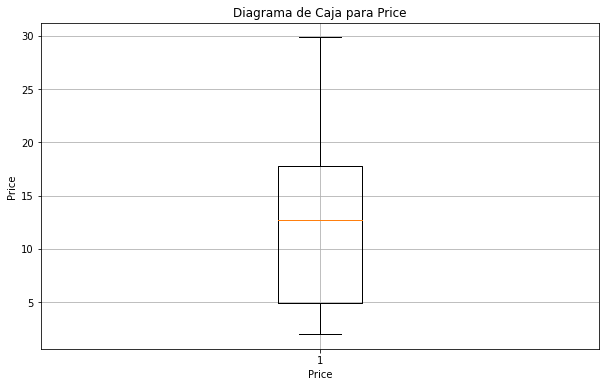

In [43]:
plt.figure(figsize=(10, 6))
plt.boxplot(df["Price"])
plt.title('Diagrama de Caja para Price')
plt.ylabel('Price')
plt.xlabel('Price')
plt.grid(True)
plt.show()

Vemos que no nos encontramos con valores outliers para esta columna.

Ahora las demas columnas como son categoricas veremos cuantas veces se repite cada variable dentro de la columna, para ver si es necesario eliminar algunas que no aporten mayor información al análisis.

In [44]:
df["RestaurantID"].value_counts()

R001    343
R003    315
R002    315
Name: RestaurantID, dtype: int64

Vemos que la columna RestaurantID esta distribuida de forma uniforme

In [45]:
df["MenuCategory"].value_counts()

Desserts       253
Beverages      248
Appetizers     248
Main Course    224
Name: MenuCategory, dtype: int64

De igual manera se encuentra la columna MenuCategory

In [46]:
df["MenuItem"].value_counts()

New York Cheesecake      70
Tiramisu                 69
Soda                     66
Vegetable Stir-Fry       66
Caprese Salad            65
Iced Tea                 64
Coffee                   63
Spinach Artichoke Dip    62
Bruschetta               62
Fruit Tart               60
Stuffed Mushrooms        59
Lemonade                 55
Grilled Steak            55
Shrimp Scampi            54
Chocolate Lava Cake      54
Chicken Alfredo          49
Name: MenuItem, dtype: int64

MenuItem, es una columna que de igual manera tiene varias variables pero se encuentra de forma uniforme distribuida

In [47]:
df["Ingredients"].value_counts()

['Chocolate', 'Butter', 'Sugar', 'Eggs']                  253
['confidential']                                          248
['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']              248
['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Parmesan']    224
Name: Ingredients, dtype: int64

Ingredients, es una columna que contiene una lista de ingredientes, podriamos separar esta lista en varias columnas, sin embargo en primera instancia lo dejaremos así, ya que al ver los valores que contiene cada uno de ellos podemos ver que las listas son solo 4 que se repiten de forma uniforme.

In [48]:
df["Profitability"].value_counts()

Medium    478
High      383
Low       112
Name: Profitability, dtype: int64

Por último nos encontramos con la variable objetivo Profitability, la cual dejaremos tal cual ya que a pesar de uqe no se encuentra de forma tan uniforme, son solo 3 valores y nos aportan información para el desarrollo del modelo.

### 4. Convertir variables categóricas a Dummies 

In [49]:
df.columns

Index(['RestaurantID', 'MenuCategory', 'MenuItem', 'Ingredients', 'Price',
       'Profitability'],
      dtype='object')

In [50]:
df = pd.get_dummies(df, columns=['RestaurantID', 'MenuCategory', 'MenuItem', 'Ingredients'])
df.shape

(973, 29)

Ahora codificaremos la variable objetivo. De la siguiente manera: Low 0, Medium 1 y High 2.

In [54]:
mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['Profitability'] = df['Profitability'].map(mapping)

In [55]:
df["Profitability"].value_counts()

1    478
2    383
0    112
Name: Profitability, dtype: int64

### 5. Normalizar variables numéricas

In [57]:
# Seleccionar las columnas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Normalización de los datos numéricos
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

## Selección de variables

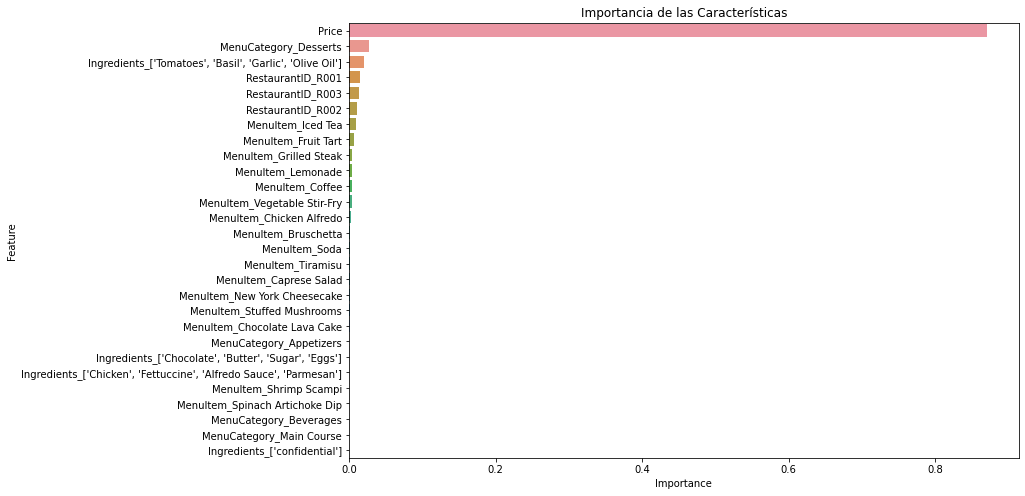

In [63]:
import seaborn as sns

all_columns = df.columns.tolist()
selected_features = [col for col in all_columns if col != 'Profitability']

# Crear y entrenar el modelo de regresión con árboles de decisión
X = df.drop('Profitability', axis=1)
y = df['Profitability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Obtener la importancia de las características
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importancia de las Características')
plt.show()

In [65]:
selected_features = df.columns
print(selected_features)

Index(['Price', 'Profitability', 'RestaurantID_R001', 'RestaurantID_R002',
       'RestaurantID_R003', 'MenuCategory_Appetizers',
       'MenuCategory_Beverages', 'MenuCategory_Desserts',
       'MenuCategory_Main Course', 'MenuItem_Bruschetta',
       'MenuItem_Caprese Salad', 'MenuItem_Chicken Alfredo',
       'MenuItem_Chocolate Lava Cake', 'MenuItem_Coffee',
       'MenuItem_Fruit Tart', 'MenuItem_Grilled Steak', 'MenuItem_Iced Tea',
       'MenuItem_Lemonade', 'MenuItem_New York Cheesecake',
       'MenuItem_Shrimp Scampi', 'MenuItem_Soda',
       'MenuItem_Spinach Artichoke Dip', 'MenuItem_Stuffed Mushrooms',
       'MenuItem_Tiramisu', 'MenuItem_Vegetable Stir-Fry',
       'Ingredients_['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Parmesan']',
       'Ingredients_['Chocolate', 'Butter', 'Sugar', 'Eggs']',
       'Ingredients_['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']',
       'Ingredients_['confidential']'],
      dtype='object')


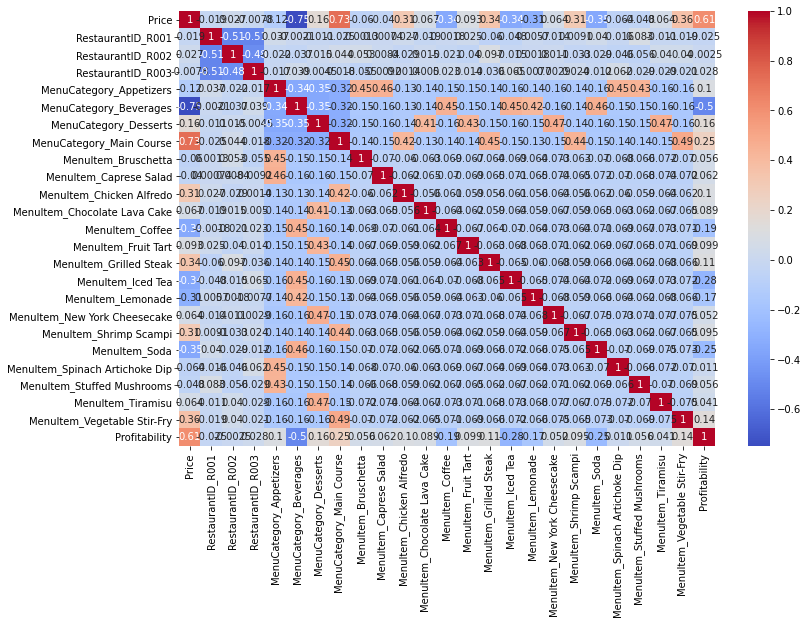

In [70]:
selected_features = ['Price', 'RestaurantID_R001', 'RestaurantID_R002','RestaurantID_R003', 'MenuCategory_Appetizers','MenuCategory_Beverages', 'MenuCategory_Desserts',
                     'MenuCategory_Main Course', 'MenuItem_Bruschetta','MenuItem_Caprese Salad', 'MenuItem_Chicken Alfredo',
                     'MenuItem_Chocolate Lava Cake', 'MenuItem_Coffee','MenuItem_Fruit Tart', 'MenuItem_Grilled Steak', 'MenuItem_Iced Tea',
                     'MenuItem_Lemonade', 'MenuItem_New York Cheesecake','MenuItem_Shrimp Scampi', 'MenuItem_Soda',
                     'MenuItem_Spinach Artichoke Dip', 'MenuItem_Stuffed Mushrooms','MenuItem_Tiramisu', 'MenuItem_Vegetable Stir-Fry']
correlation_matrix = df[selected_features + ['Profitability']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

En primera instancia dejaremos todas las columnas para ver que resultados obtendremos

In [58]:
# Seleccionar las características y la variable objetivo
X = df.drop(columns=['Profitability'])
y = df['Profitability']

## Desarrollo y evaluación de modelos

Regresión Lineal

In [59]:
# Primero deberíamos seleccionar las características y la variable objetivo
# Pero ya fueron seleccionadas en el paso anterior

# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = linear_model.predict(X_test)

# Calcular métricas
linear_r2 = r2_score(y_test, y_pred)
linear_mae = mean_absolute_error(y_test, y_pred)
linear_mse = mean_squared_error(y_test, y_pred)

print(f'Linear Regression R2: {linear_r2}')
print(f'Linear Regression MAE: {linear_mae}')

Linear Regression R2: 0.3829012111144653
Linear Regression MAE: 0.1838817107371795


Arbol de decisión

In [61]:
from sklearn.tree import export_graphviz
from IPython.display import Image
from six import StringIO
import pydotplus

def display_tree(dt):
    dot_data = StringIO()
    export_graphviz(dt, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())


# Primero deberíamos seleccionar las características y la variable objetivo
# Pero ya fueron seleccionadas en el paso anterior

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

tree = DecisionTreeRegressor(random_state=21, max_depth=20)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)


tree_r2 = r2_score(y_test, y_pred)
tree_mae = mean_absolute_error(y_test, y_pred)

print(f'Decision Tree R2: {tree_r2}')
print(f'Decision Tree MAE: {tree_mae}')

Decision Tree R2: 0.456231813773036
Decision Tree MAE: 0.07179487179487179


Random Forest

In [62]:
from sklearn.ensemble import RandomForestRegressor


# Primero deberíamos seleccionar las características y la variable objetivo
# Pero ya fueron seleccionadas en el paso anterior


# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo de Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred = rf_model.predict(X_test_scaled)

# Calcular métricas
rf_r2 = r2_score(y_test, y_pred)
rf_mae = mean_absolute_error(y_test, y_pred)

print(f'Random Forest R2: {rf_r2}')
print(f'Random Forest MAE: {rf_mae}')

Random Forest R2: 0.39834835318329787
Random Forest MAE: 0.12591666666666668


## Reflexión